In [1]:
import warnings; warnings.filterwarnings("ignore")

</br>

* **data processing (Merge all data)**

In [ ]:
import numpy as np

X_kmer = np.load('K-mer.npy')
X_revk = np.load('rev-k-mer.npy')
X_gapk = np.load('gapped_k_mer.npy')

In [ ]:
print(X_kmer.shape)
print(X_revk.shape)
print(X_gapk.shape)

(1081, 340)
(1081, 340)
(1081, 80)


In [ ]:
Y  = [1 for i in range(490)]
Y += [0 for i in range(591)]
Y = np.array(Y)
print(Y.shape)

(1081,)


In [ ]:
X = np.concatenate((X_kmer,X_revk, X_gapk),axis=1)

In [ ]:
X.shape

(1081, 760)

</br>

* **Shuffle**

In [ ]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)

print(X.shape)
print(Y.shape)

(1081, 760)
(1081,)


In [ ]:
X.shape

(1081, 760)

In [ ]:
X = X.reshape(-1, 760, 1)
X.shape

(1081, 760, 1)

In [ ]:
X[0].shape

(760, 1)

In [ ]:
# for _ in Y:
#     print(_)

In [ ]:
# Deep Neural Networks:
import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
# import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)
from tensorflow.keras.regularizers import (l1, l2, l1_l2)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from tensorflow.keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.patches as patches

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score, roc_curve, auc)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical as labelEncoding   # Usages: Y = labelEncoding(Y, dtype=int)
from tensorflow.keras.utils import plot_model                        # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)

#end-import

We're using TF-2.3.0.


In [ ]:
Y = labelEncoding(Y, dtype=int)
Y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [ ]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['accuracy'], label='Training Accuracy')
    plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

def rocPlot(TPR, meanFPR):
    plt.plot([0,1], [0,1],linestyle = '--',lw = 2,color = 'black')
    meanTPR = np.mean(TPR, axis=0)
    meanAUC = auc(meanFPR, meanTPR)
    plt.plot(meanFPR, meanTPR, color='blue',
            label=r'Mean ROC (AUC = %0.2f )' % (meanAUC),lw=2, alpha=1)

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
    plt.legend(loc="lower right")
    plt.savefig('ROC-240.png')
    plt.show()
#end-def

In [ ]:
def Network():
    ### Head-1:
    input1 = Input(shape=(760, 1))

    # Good-begin
    # x = Conv1D(filters=16, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input1)
    # x = BatchNormalization()(x)
    # x = Dropout(rate=0.80)(x)
    # Good-end

    x = Conv1D(filters=128, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=64, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)
    
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)
    
    x = Flatten()(x)
        
    x = Dense(units=16, activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = Dropout(rate=0.80)(x)
    x = Dense(units=8, activation='relu', kernel_regularizer=l2(l=0.01))(x)
    o = Dense(units=2, activation='softmax')(x)

    return Model(inputs=[input1], outputs=[o])
#end-def

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 760, 1)]          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 760, 128)          640       
_________________________________________________________________
batch_normalization_32 (Batc (None, 760, 128)          512       
_________________________________________________________________
dropout_40 (Dropout)         (None, 760, 128)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 760, 64)           32832     
_________________________________________________________________
batch_normalization_33 (Batc (None, 760, 64)           256       
_________________________________________________________________
dropout_41 (Dropout)         (None, 760, 64)         

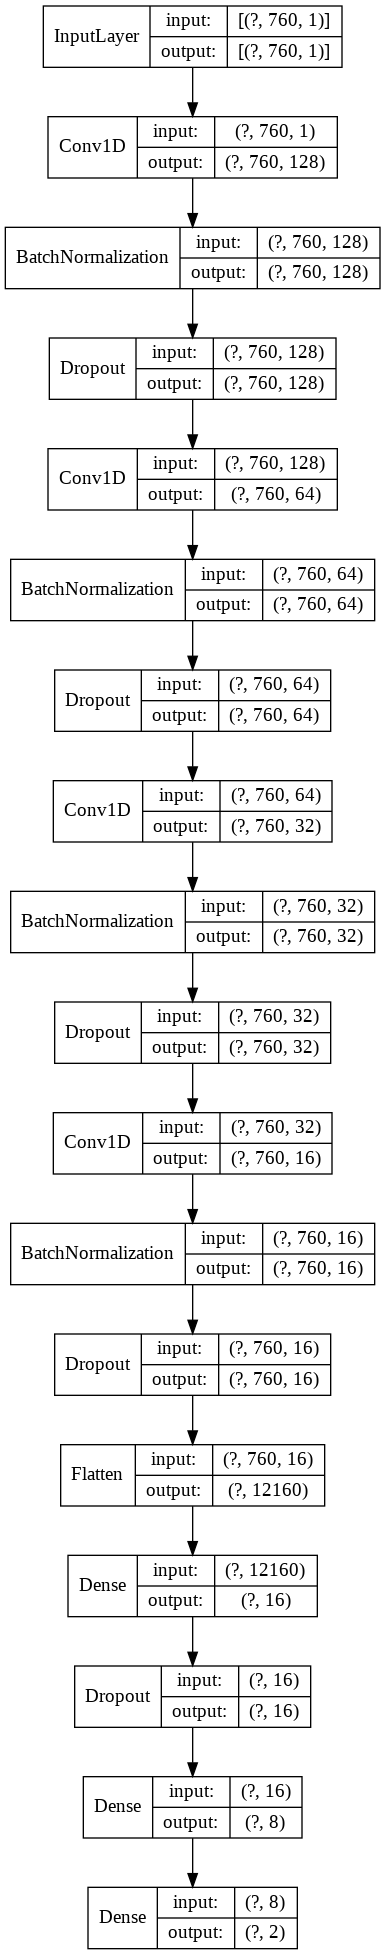

In [ ]:
model = Network()
model.summary()
plot_model(model, to_file='model-Nasif.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [ ]:
X.shape

(1081, 760, 1)

Epoch 1/750
108/108 [==============================] - 1s 9ms/step - loss: 2.9418 - accuracy: 0.4861 - val_loss: 2.4976 - val_accuracy: 0.4885
Epoch 2/750
108/108 [==============================] - 1s 6ms/step - loss: 2.5290 - accuracy: 0.4907 - val_loss: 2.4525 - val_accuracy: 0.5115
Epoch 3/750
108/108 [==============================] - 1s 6ms/step - loss: 2.4540 - accuracy: 0.5428 - val_loss: 2.3999 - val_accuracy: 0.5115
Epoch 4/750
108/108 [==============================] - 1s 6ms/step - loss: 2.3857 - accuracy: 0.5463 - val_loss: 2.3411 - val_accuracy: 0.5115
Epoch 5/750
108/108 [==============================] - 1s 6ms/step - loss: 2.3148 - accuracy: 0.5509 - val_loss: 2.2808 - val_accuracy: 0.5115
Epoch 6/750
108/108 [==============================] - 1s 6ms/step - loss: 2.2442 - accuracy: 0.5567 - val_loss: 2.2138 - val_accuracy: 0.5115
Epoch 7/750
108/108 [==============================] - 1s 6ms/step - loss: 2.1787 - accuracy: 0.5532 - val_loss: 2.1470 - val_accuracy: 0.5115

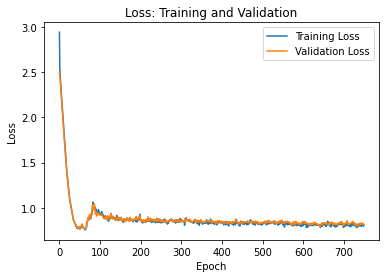

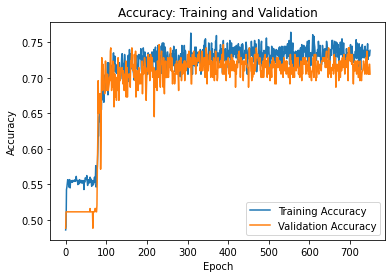

#################################################
Epoch 1/750
109/109 [==============================] - 1s 10ms/step - loss: 3.1359 - accuracy: 0.5225 - val_loss: 2.4698 - val_accuracy: 0.5509
Epoch 2/750
109/109 [==============================] - 1s 7ms/step - loss: 2.5064 - accuracy: 0.5341 - val_loss: 2.4361 - val_accuracy: 0.5509
Epoch 3/750
109/109 [==============================] - 1s 7ms/step - loss: 2.4646 - accuracy: 0.5422 - val_loss: 2.3929 - val_accuracy: 0.5509
Epoch 4/750
109/109 [==============================] - 1s 7ms/step - loss: 2.3904 - accuracy: 0.5468 - val_loss: 2.3444 - val_accuracy: 0.5509
Epoch 5/750
109/109 [==============================] - 1s 7ms/step - loss: 2.3275 - accuracy: 0.5457 - val_loss: 2.2927 - val_accuracy: 0.5509
Epoch 6/750
109/109 [==============================] - 1s 7ms/step - loss: 2.2729 - accuracy: 0.5480 - val_loss: 2.2349 - val_accuracy: 0.5509
Epoch 7/750
109/109 [==============================] - 1s 7ms/step - loss: 2.2256 - accurac

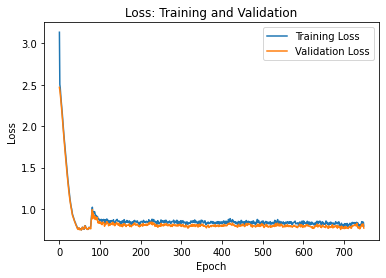

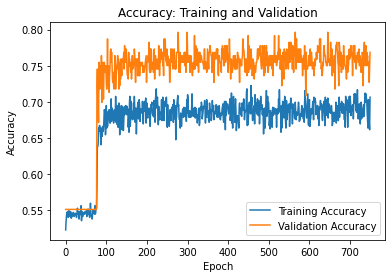

#################################################
Epoch 1/750
109/109 [==============================] - 1s 10ms/step - loss: 2.7027 - accuracy: 0.5064 - val_loss: 2.4617 - val_accuracy: 0.5370
Epoch 2/750
109/109 [==============================] - 1s 8ms/step - loss: 2.4917 - accuracy: 0.4948 - val_loss: 2.3996 - val_accuracy: 0.5370
Epoch 3/750
109/109 [==============================] - 1s 7ms/step - loss: 2.3902 - accuracy: 0.5133 - val_loss: 2.3320 - val_accuracy: 0.5370
Epoch 4/750
109/109 [==============================] - 1s 8ms/step - loss: 2.2959 - accuracy: 0.5434 - val_loss: 2.2494 - val_accuracy: 0.5370
Epoch 5/750
109/109 [==============================] - 1s 7ms/step - loss: 2.2058 - accuracy: 0.5526 - val_loss: 2.1597 - val_accuracy: 0.5370
Epoch 6/750
109/109 [==============================] - 1s 7ms/step - loss: 2.1160 - accuracy: 0.5538 - val_loss: 2.0704 - val_accuracy: 0.5370
Epoch 7/750
109/109 [==============================] - 1s 8ms/step - loss: 2.0301 - accurac

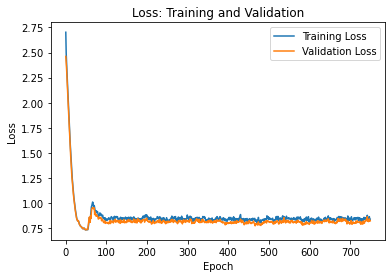

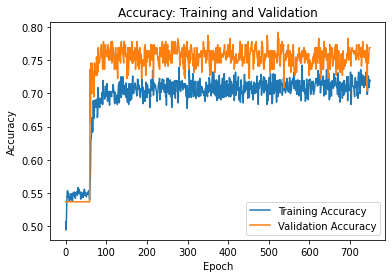

#################################################
Epoch 1/750
109/109 [==============================] - 1s 10ms/step - loss: 3.1847 - accuracy: 0.5064 - val_loss: 2.4349 - val_accuracy: 0.4167
Epoch 2/750
109/109 [==============================] - 1s 8ms/step - loss: 2.5147 - accuracy: 0.4671 - val_loss: 2.3996 - val_accuracy: 0.4167
Epoch 3/750
109/109 [==============================] - 1s 7ms/step - loss: 2.4077 - accuracy: 0.4763 - val_loss: 2.3592 - val_accuracy: 0.4167
Epoch 4/750
109/109 [==============================] - 1s 8ms/step - loss: 2.3841 - accuracy: 0.4647 - val_loss: 2.3199 - val_accuracy: 0.4167
Epoch 5/750
109/109 [==============================] - 1s 7ms/step - loss: 2.3237 - accuracy: 0.4671 - val_loss: 2.2709 - val_accuracy: 0.4167
Epoch 6/750
109/109 [==============================] - 1s 8ms/step - loss: 2.2548 - accuracy: 0.5121 - val_loss: 2.2195 - val_accuracy: 0.5833
Epoch 7/750
109/109 [==============================] - 1s 8ms/step - loss: 2.1936 - accurac

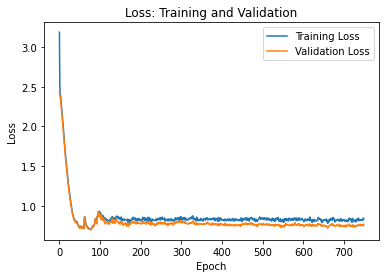

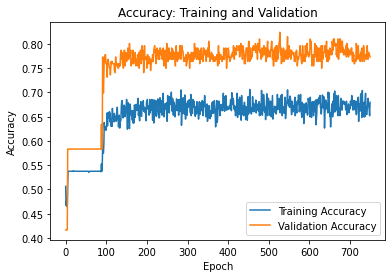

#################################################
Epoch 1/750
109/109 [==============================] - 1s 10ms/step - loss: 2.9229 - accuracy: 0.4983 - val_loss: 2.4956 - val_accuracy: 0.5509
Epoch 2/750
109/109 [==============================] - 1s 8ms/step - loss: 2.5303 - accuracy: 0.5202 - val_loss: 2.4525 - val_accuracy: 0.5509
Epoch 3/750
109/109 [==============================] - 1s 7ms/step - loss: 2.4421 - accuracy: 0.5214 - val_loss: 2.3929 - val_accuracy: 0.5509
Epoch 4/750
109/109 [==============================] - 1s 8ms/step - loss: 2.3655 - accuracy: 0.5410 - val_loss: 2.3219 - val_accuracy: 0.5509
Epoch 5/750
109/109 [==============================] - 1s 8ms/step - loss: 2.2846 - accuracy: 0.5480 - val_loss: 2.2446 - val_accuracy: 0.5509
Epoch 6/750
109/109 [==============================] - 1s 8ms/step - loss: 2.2109 - accuracy: 0.5376 - val_loss: 2.1679 - val_accuracy: 0.5509
Epoch 7/750
109/109 [==============================] - 1s 7ms/step - loss: 2.1328 - accurac

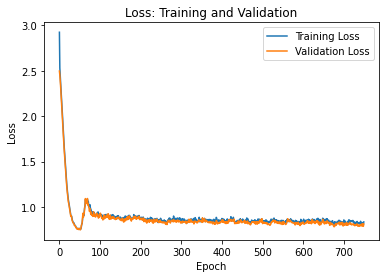

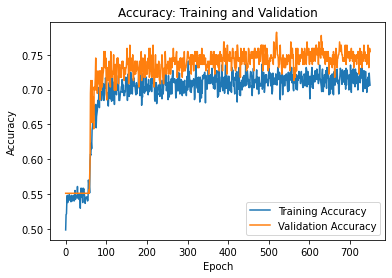

#################################################
Accuracy [Each Fold]: [0.7050691246986389, 0.7685185074806213, 0.7685185074806213, 0.7731481194496155, 0.7546296119689941]
Accuracy: 0.75
Sensitivity: 0.5504
Specificity: 0.9239
MCC: 0.5206
Precision: 0.8594


In [55]:
setEpochNumber     = 750     # Performed-welled in epoch 600.
setBatchSizeNumber = 8
####################################################
fold = 5
cv = KFold(n_splits=fold, shuffle=True, random_state=101)

Accuracy = []
Sensitivity = []
Specificity = []
Precision = []
MCC = []

# ROC Curve:
# fig = plt.figure(figsize=[12,12])

TPR = []
meanFPR = np.linspace(0, 1, 100)

i = 1
plotCount = 1

# stopEpoch = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto',)

for train, test in cv.split(Y):

    # Compile Model:
    model = Network()
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


    # Run Model:
    results = model.fit(x=X[train,:,:],
                        y=Y[train,:],
                        validation_data=(X[test,:,:], Y[test,:]),
                        batch_size=setBatchSizeNumber, epochs=setEpochNumber,
                        callbacks = [],
              )
    
#     # Performance Plot
#     print('#################################################')
# #     print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
# #     lossPlot(results)
# #     accuracyPlot(results)
#     print('#################################################')

    accuracy = model.evaluate(x=X[test,:,:], y=Y[test,:], batch_size=setBatchSizeNumber)
    Accuracy.append(accuracy[1])

    # Performance Metices:
    Yactual = Y[test,:].argmax(axis=1)
    Yp = model.predict(X[test,:,:])
    v = Yp
    Yp = Yp.argmax(axis=1)

    CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
    TN, FP, FN, TP = CM.ravel()

    MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
    Sensitivity.append( TP / (TP + FN) )
    Specificity.append( TN / (TN + FP) )
    Precision.append(precision_score(y_true=Yactual, y_pred=Yp))
    
    # ROC Curve
    # fpr, tpr, _ = roc_curve(Yactual, v[:,1])
    # TPR.append(interp(meanFPR, fpr, tpr))
    # rocauc = auc(fpr, tpr)
    # plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, rocauc))
    # i= i+1
    
    # Performance Plot
    print('#################################################')
    print('Fold\'s Accuracy-{}: {:.2f}'.format(plotCount, accuracy[1]*100.0))
    lossPlot(results)
    accuracyPlot(results)
    plotCount += 1
    print('#################################################')

    
#end-for

# rocPlot(TPR, meanFPR)

print('Accuracy [Each Fold]: {}'.format(Accuracy))
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/fold))
print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/fold))
print('Specificity: {0:.4f}'.format(np.sum(Specificity)/fold))
print('MCC: {0:.4f}'.format(np.sum(MCC)/fold))
print('Precision: {0:.4f}'.format(np.sum(Precision)/fold))